In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!rm -rf ssd
!mkdir ssd
!mkdir ssd/checkpoints
!mkdir ssd/checkpoints/soups
!mkdir results

In [ ]:
!pip install wget
!pip install clip
!pip install datasets
!pip install GPUtil pytorch_pretrained_bert transformers
!pip uninstall emoji
!pip install emoji==1.7

!pip install barbar

In [ ]:
from emoji import UNICODE_EMOJI
import wget
import clip
from transformers import AutoModel
from barbar import Bar
from transformers import AutoTokenizer, AutoModel

In [ ]:


import os

import torch

import os
import json
import operator

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import time
import torch.nn as nn
import torch

import torch.nn.functional as F
from torch.autograd import Variable
import re
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
import pandas as pd

In [ ]:
dic = {
      "egypt": 'المصرية',
	  "nile": 'المصرية',
	  "msa": "اللغة العربية الفصحى",
	  "magreb": "المغربية",
	  "gulf": "الخليجية",
	  "levant": "الشامية"
}

In [ ]:

UNIFORM_SOUP_RESULTS_FILE_H = 'uniform_soup_results_h.jsonl'
UNIFORM_SOUP_RESULTS_FILE_T = 'uniform_soup_results_t.jsonl'

GREEDY_SOUP_RESULTS_FILE_H = 'greedy_soup_results_h.jsonl'
GREEDY_SOUP_RESULTS_FILE_T = 'greedy_soup_results_t.jsonl'

# RNN models

In [ ]:
class GRUCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        self.x2h = nn.Linear(input_size, 3 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 3 * hidden_size, bias=bias)

        self.reset_parameters()


    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, hx=None):

        # Inputs:
        #       input: of shape (batch_size, input_size)
        #       hx: of shape (batch_size, hidden_size)
        # Output:
        #       hy: of shape (batch_size, hidden_size)

        if hx is None:
            hx = Variable(input.new_zeros(input.size(0), self.hidden_size))

        x_t = self.x2h(input)
        h_t = self.h2h(hx)


        x_reset, x_upd, x_new = x_t.chunk(3, 1)
        h_reset, h_upd, h_new = h_t.chunk(3, 1)

        reset_gate = torch.sigmoid(x_reset + h_reset)
        update_gate = torch.sigmoid(x_upd + h_upd)
        new_gate = torch.tanh(x_new + (reset_gate * h_new))

        hy = update_gate * hx + (1 - update_gate) * new_gate

        return hy



class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, bias, output_size):
        super(GRU, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size

        self.rnn_cell_list = nn.ModuleList()

        self.rnn_cell_list.append(GRUCell(self.input_size,
                                          self.hidden_size,
                                          self.bias))
        for l in range(1, self.num_layers):
            self.rnn_cell_list.append(GRUCell(self.hidden_size,
                                              self.hidden_size,
                                              self.bias))
        self.fc = nn.Linear(self.hidden_size, self.output_size)


    def forward(self, input, hx=None):

        # Input of shape (batch_size, seqence length, input_size)
        #
        # Output of shape (batch_size, output_size)

        if hx is None:
            if torch.cuda.is_available():
                h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size).cuda())
            else:
                h0 = Variable(torch.zeros(self.num_layers, input.size(0), self.hidden_size))

        else:
             h0 = hx

        outs = []

        hidden = list()
        for layer in range(self.num_layers):
            hidden.append(h0[layer, :, :])

        for t in range(input.size(1)):

            for layer in range(self.num_layers):

                if layer == 0:
                    hidden_l = self.rnn_cell_list[layer](input[:, t, :], hidden[layer])
                else:
                    hidden_l = self.rnn_cell_list[layer](hidden[layer - 1],hidden[layer])
                hidden[layer] = hidden_l

                hidden[layer] = hidden_l

            outs.append(hidden_l)

        # Take only last time step. Modify for seq to seq
        out = outs[-1].squeeze()

        out = self.fc(out)

        return out


# utils

In [ ]:
def plot_cf(cf_matrix):
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt="d")
    ax.set_title('Seaborn Confusion Matrix with labels\n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ');
    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    ## Display the visualization of the Confusion Matrix.
    plt.show()

In [ ]:
def calc_accuracy(preds,y):
    predict = torch.argmax(preds, dim=1)
    accuracy = torch.sum(predict == y.squeeze()).float().item()
    return accuracy / float(preds.size()[0])

In [ ]:
def assign_learning_rate(param_group, new_lr):
    param_group["lr"] = new_lr

In [ ]:
def _warmup_lr(base_lr, warmup_length, step):
    return base_lr * (step + 1) / warmup_length

In [ ]:
def cosine_lr(optimizer, base_lrs, warmup_length, steps):
    if not isinstance(base_lrs, list):
        base_lrs = [base_lrs for _ in optimizer.param_groups]
    assert len(base_lrs) == len(optimizer.param_groups)
    def _lr_adjuster(step):
        for param_group, base_lr in zip(optimizer.param_groups, base_lrs):
            if step < warmup_length:
                lr = _warmup_lr(base_lr, warmup_length, step)
            else:
                e = step - warmup_length
                es = steps - warmup_length
                lr = 0.5 * (1 + np.cos(np.pi * e / es)) * base_lr
            assign_learning_rate(param_group, lr)
    return _lr_adjuster

# main

In [ ]:


args = {"data_location": os.path.expanduser('./data'),
        "model_location": os.path.expanduser('./ssd/checkpoints/soups'),
        "download_models": False,
        "eval_individual_models":True,
        "uniform_soup": True,
        "greedy_soup": True,
        "plot": True,
        "batch_size": 36,
        "workers": 8,
        "pretrained_path": "UBC-NLP/MARBERT",
        'loss' : 'FL',
        'max_length': 64

}



In [ ]:
args

{'data_location': './data',
 'model_location': './ssd/checkpoints/soups',
 'download_models': False,
 'eval_individual_models': True,
 'uniform_soup': True,
 'greedy_soup': True,
 'plot': True,
 'batch_size': 36,
 'workers': 8,
 'pretrained_path': 'UBC-NLP/MARBERT',
 'loss': 'FL',
 'max_length': 64}

In [ ]:

args["model_location"]

'./ssd/checkpoints/soups'

In [ ]:
if not os.path.exists(args["model_location"]):
    os.mkdir(args["model_location"])

In [ ]:
ls ./ssd/checkpoints/soups

In [ ]:
!cp -av "/content/drive/MyDrive/iSarcasm/m_298/."  "./ssd/checkpoints/soups"

'/content/drive/MyDrive/iSarcasm/m_298/./best_basemodel_sarcasm_16_FL_1e-05_ml64_2_298_sarcat.pth' -> './ssd/checkpoints/soups/./best_basemodel_sarcasm_16_FL_1e-05_ml64_2_298_sarcat.pth'
'/content/drive/MyDrive/iSarcasm/m_298/./best_cls_sarcasm_16_FL_1e-05_ml64_2_298_sarcat.pth' -> './ssd/checkpoints/soups/./best_cls_sarcasm_16_FL_1e-05_ml64_2_298_sarcat.pth'
'/content/drive/MyDrive/iSarcasm/m_298/./best_basemodel_sarcasm_16_FL_1e-05_ml64_4_298_sarcat.pth' -> './ssd/checkpoints/soups/./best_basemodel_sarcasm_16_FL_1e-05_ml64_4_298_sarcat.pth'
'/content/drive/MyDrive/iSarcasm/m_298/./best_cls_sarcasm_16_FL_1e-05_ml64_4_298_sarcat.pth' -> './ssd/checkpoints/soups/./best_cls_sarcasm_16_FL_1e-05_ml64_4_298_sarcat.pth'
'/content/drive/MyDrive/iSarcasm/m_298/./best_basemodel_sarcasm_32_FL_1e-05_ml64_2_298_sarcat.pth' -> './ssd/checkpoints/soups/./best_basemodel_sarcasm_32_FL_1e-05_ml64_2_298_sarcat.pth'
'/content/drive/MyDrive/iSarcasm/m_298/./best_cls_sarcasm_32_FL_1e-05_ml64_2_298_sarcat.p

In [ ]:
model_paths_base = []


In [ ]:
model_paths_cls = []


In [ ]:
base_dict  = {}
cls_dict={}
directory = './ssd/checkpoints/soups'
for filename in os.listdir(directory):

    if filename.startswith('best_basemodel_'):
        arr = filename.split("_")
        model_name = arr[3]+"_"+arr[4]+"_"+arr[5]+"_"+arr[7]+"_"+arr[8]
        base_dict[model_name]= filename
        model_paths_base.append(filename)
    if filename.startswith('best_cls_'):
        arr = filename.split("_")
        model_name = arr[3]+"_"+arr[4]+"_"+arr[5]+"_"+arr[7]+"_"+arr[8]
        cls_dict[model_name]=filename
        model_paths_cls.append(filename)

In [ ]:
model_paths_base

['best_basemodel_sarcasm_32_FL_1e-05_ml64_2_298_sarcat.pth',
 'best_basemodel_sarcasm_64_FL_1e-05_ml64_4_298_sarcat.pth',
 'best_basemodel_sarcasm_16_FL_1e-05_ml64_4_298_sarcat.pth',
 'best_basemodel_sarcasm_64_FL_2e-05_ml64_4_298_sarcat.pth',
 'best_basemodel_sarcasm_32_FL_2e-05_ml64_4_298_sarcat.pth',
 'best_basemodel_sarcasm_32_FL_2e-05_ml64_2_298_sarcat.pth',
 'best_basemodel_sarcasm_64_FL_1e-05_ml64_2_298_sarcat.pth',
 'best_basemodel_sarcasm_36_FL_2e-05_ml64_4_298_sarcat.pth',
 'best_basemodel_sarcasm_16_FL_2e-05_ml64_4_298_sarcat.pth',
 'best_basemodel_sarcasm_36_FL_1e-05_ml64_4_298_sarcat.pth',
 'best_basemodel_sarcasm_16_FL_1e-05_ml64_2_298_sarcat.pth',
 'best_basemodel_sarcasm_64_FL_2e-05_ml64_2_298_sarcat.pth',
 'best_basemodel_sarcasm_16_FL_2e-05_ml64_2_298_sarcat.pth',
 'best_basemodel_sarcasm_32_FL_1e-05_ml64_4_298_sarcat.pth',
 'best_basemodel_sarcasm_36_FL_1e-05_ml64_2_298_sarcat.pth',
 'best_basemodel_sarcasm_36_FL_2e-05_ml64_2_298_sarcat.pth']

In [ ]:
model_paths_cls

['best_cls_sarcasm_32_FL_1e-05_ml64_4_298_sarcat.pth',
 'best_cls_sarcasm_36_FL_1e-05_ml64_2_298_sarcat.pth',
 'best_cls_sarcasm_32_FL_2e-05_ml64_2_298_sarcat.pth',
 'best_cls_sarcasm_32_FL_1e-05_ml64_2_298_sarcat.pth',
 'best_cls_sarcasm_36_FL_2e-05_ml64_2_298_sarcat.pth',
 'best_cls_sarcasm_16_FL_1e-05_ml64_4_298_sarcat.pth',
 'best_cls_sarcasm_32_FL_2e-05_ml64_4_298_sarcat.pth',
 'best_cls_sarcasm_36_FL_2e-05_ml64_4_298_sarcat.pth',
 'best_cls_sarcasm_64_FL_1e-05_ml64_4_298_sarcat.pth',
 'best_cls_sarcasm_16_FL_2e-05_ml64_4_298_sarcat.pth',
 'best_cls_sarcasm_16_FL_1e-05_ml64_2_298_sarcat.pth',
 'best_cls_sarcasm_36_FL_1e-05_ml64_4_298_sarcat.pth',
 'best_cls_sarcasm_64_FL_2e-05_ml64_4_298_sarcat.pth',
 'best_cls_sarcasm_16_FL_2e-05_ml64_2_298_sarcat.pth',
 'best_cls_sarcasm_64_FL_1e-05_ml64_2_298_sarcat.pth',
 'best_cls_sarcasm_64_FL_2e-05_ml64_2_298_sarcat.pth']

In [ ]:
base_dict

{'32_FL_1e-05_2_298': 'best_basemodel_sarcasm_32_FL_1e-05_ml64_2_298_sarcat.pth',
 '64_FL_1e-05_4_298': 'best_basemodel_sarcasm_64_FL_1e-05_ml64_4_298_sarcat.pth',
 '16_FL_1e-05_4_298': 'best_basemodel_sarcasm_16_FL_1e-05_ml64_4_298_sarcat.pth',
 '64_FL_2e-05_4_298': 'best_basemodel_sarcasm_64_FL_2e-05_ml64_4_298_sarcat.pth',
 '32_FL_2e-05_4_298': 'best_basemodel_sarcasm_32_FL_2e-05_ml64_4_298_sarcat.pth',
 '32_FL_2e-05_2_298': 'best_basemodel_sarcasm_32_FL_2e-05_ml64_2_298_sarcat.pth',
 '64_FL_1e-05_2_298': 'best_basemodel_sarcasm_64_FL_1e-05_ml64_2_298_sarcat.pth',
 '36_FL_2e-05_4_298': 'best_basemodel_sarcasm_36_FL_2e-05_ml64_4_298_sarcat.pth',
 '16_FL_2e-05_4_298': 'best_basemodel_sarcasm_16_FL_2e-05_ml64_4_298_sarcat.pth',
 '36_FL_1e-05_4_298': 'best_basemodel_sarcasm_36_FL_1e-05_ml64_4_298_sarcat.pth',
 '16_FL_1e-05_2_298': 'best_basemodel_sarcasm_16_FL_1e-05_ml64_2_298_sarcat.pth',
 '64_FL_2e-05_2_298': 'best_basemodel_sarcasm_64_FL_2e-05_ml64_2_298_sarcat.pth',
 '16_FL_2e-05_2_

In [ ]:
cls_dict

{'32_FL_1e-05_4_298': 'best_cls_sarcasm_32_FL_1e-05_ml64_4_298_sarcat.pth',
 '36_FL_1e-05_2_298': 'best_cls_sarcasm_36_FL_1e-05_ml64_2_298_sarcat.pth',
 '32_FL_2e-05_2_298': 'best_cls_sarcasm_32_FL_2e-05_ml64_2_298_sarcat.pth',
 '32_FL_1e-05_2_298': 'best_cls_sarcasm_32_FL_1e-05_ml64_2_298_sarcat.pth',
 '36_FL_2e-05_2_298': 'best_cls_sarcasm_36_FL_2e-05_ml64_2_298_sarcat.pth',
 '16_FL_1e-05_4_298': 'best_cls_sarcasm_16_FL_1e-05_ml64_4_298_sarcat.pth',
 '32_FL_2e-05_4_298': 'best_cls_sarcasm_32_FL_2e-05_ml64_4_298_sarcat.pth',
 '36_FL_2e-05_4_298': 'best_cls_sarcasm_36_FL_2e-05_ml64_4_298_sarcat.pth',
 '64_FL_1e-05_4_298': 'best_cls_sarcasm_64_FL_1e-05_ml64_4_298_sarcat.pth',
 '16_FL_2e-05_4_298': 'best_cls_sarcasm_16_FL_2e-05_ml64_4_298_sarcat.pth',
 '16_FL_1e-05_2_298': 'best_cls_sarcasm_16_FL_1e-05_ml64_2_298_sarcat.pth',
 '36_FL_1e-05_4_298': 'best_cls_sarcasm_36_FL_1e-05_ml64_4_298_sarcat.pth',
 '64_FL_2e-05_4_298': 'best_cls_sarcasm_64_FL_2e-05_ml64_4_298_sarcat.pth',
 '16_FL_2e-0

In [ ]:
def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1 or classname.find('ConvTranspose2d') != -1:
        nn.init.kaiming_uniform_(m.weight)
        nn.init.zeros_(m.bias)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.zeros_(m.bias)
    elif classname.find('Linear') != -1:
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [ ]:

class TransformerLayer(nn.Module):
    def __init__(self,both=True,
                pretrained_path='aubmindlab/bert-base-arabert'):
        super(TransformerLayer, self).__init__()

        self.both = both
        self.transformer = AutoModel.from_pretrained(pretrained_path, output_hidden_states=True)


    def forward(self, input_ids=None, attention_mask=None):
        outputs = self.transformer(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        # (output_last_layer, pooled_cls, (output_layers))
        # output[0] (8, seqlen=64, 768) cls [8, 768] ( 12 (8, seqlen=64, 768))

        return outputs

    def output_num(self):
        return self.transformer.config.hidden_size

class ATTClassifier(nn.Module):
    def __init__(self, in_feature, class_num=1, dropout_prob=0.2):
        super(ATTClassifier, self).__init__()
        # self.attention = AttentionWithContext(in_feature)
        self.model = GRU(input_size=in_feature, hidden_size=in_feature, num_layers=1, bias=True , output_size=in_feature)

        self.Classifier = nn.Sequential(
            nn.Linear(2 * in_feature, 512),
            nn.Dropout(dropout_prob),
            nn.ReLU(),
            nn.Linear(512, class_num)
        )

        self.apply(init_weights)

    def forward(self, x):

        mod = self.model(x[0]) #(X[0] (bs, seqlenght, embedD) att = \sum_i alpha_i x[0][i]
        xx = torch.cat([mod, x[1]], 1)

        out = self.Classifier(xx)
        return out


In [ ]:
def is_emoji(s):
    return s in UNICODE_EMOJI

In [ ]:
def add_space(text):
    return ''.join(' ' + char if is_emoji(char) else char for char in text).strip()

In [ ]:
def preprocess(text, lang='ar'):
    sent = add_space(text)
    sent = re.sub(r'(?:@[\w_]+)', "user", sent)
    sent = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', "url", sent)
    sent = sent.replace('_', ' ')
    sent = sent.replace('#', ' ')
    return sent

def prepare_text(df, col='tweet'):
    if col == 'tweet':
        df['dialect'] = df['dialect'].map(dic)
    for i in range(df.shape[0]):
        df.loc[i, col] = df.loc[i, 'dialect'] + ' [SEP] ' + df.loc[i, col]


    return df

In [ ]:
class TrainDataset(Dataset):
    def __init__(self, df, pretraine_path='xlm-roberta-base', max_length=128):
        self.df = df
        self.max_length = max_length

        self.tokenizer = AutoTokenizer.from_pretrained(pretraine_path)

    def __getitem__(self, index):
        text = self.df.iloc[index]['tweet']
        label = self.df.iloc[index]["sarcastic"]
        #print("label", label)

        encoded_input = self.tokenizer(
                text,
                max_length = self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors="pt",
            )

        input_ids = encoded_input["input_ids"]
        attention_mask = encoded_input["attention_mask"] if "attention_mask" in encoded_input else None

        data_input = {
            "input_ids":input_ids.flatten(),
            "attention_mask": attention_mask.flatten()
        }

        label_input ={
            "sarcasm": torch.tensor(label, dtype=torch.float),
        }

        return data_input, label_input

    def __len__(self):
        return self.df.shape[0]

In [ ]:
def loadValData(batchsize=16, num_worker=2, pretraine_path="xlm-roberta-base", max_length=128):
    path = "/content/drive/MyDrive/iSarcasm/Datasets2/split_80_20/val.csv"
    data = pd.read_csv(path, encoding='utf-8')
    data['tweet'] = data['tweet'].apply(lambda x:preprocess(x))
    print(data.shape)
    print(data.head())

    data = prepare_text(data, col='tweet')

    DF_test = TrainDataset(data, pretraine_path, max_length)

    DF_test_loader = DataLoader(dataset=DF_test, batch_size=batchsize, shuffle=False,
                                num_workers=num_worker)
    return DF_test_loader



In [ ]:
def loadTestData(batchsize=16, num_worker=2, pretraine_path="xlm-roberta-base", max_length=128):
    path = "/content/drive/MyDrive/iSarcasm/Datasets2/tweet/task_A_Ar_test.csv"
    data = pd.read_csv(path, encoding='utf-8')
    data['tweet'] = data['tweet'].apply(lambda x:preprocess(x))
    data = prepare_text(data, col='tweet')

    DF_test = TrainDataset(data, pretraine_path, max_length)

    DF_test_loader = DataLoader(dataset=DF_test, batch_size=batchsize, shuffle=False,
                                num_workers=num_worker)


    return DF_test_loader



In [ ]:
def loadExamplesData(batchsize=16, num_worker=2, pretraine_path="xlm-roberta-base", max_length=128):
    path = "/content/drive/MyDrive/iSarcasm/Datasets2/tweet/examples.csv"
    data = pd.read_csv(path, encoding='utf-8')
    data['tweet'] = data['tweet'].apply(lambda x:preprocess(x))
    data = prepare_text(data, col='tweet')

    DF_test = TrainDataset(data, pretraine_path, max_length)

    DF_test_loader = DataLoader(dataset=DF_test, batch_size=batchsize, shuffle=False,
                                num_workers=num_worker)


    return DF_test_loader



In [ ]:
def predict(base_model, mt_classifier, iterator):
    # initialize every epoch
    acc_sarcasm= 0
    loss_sarc= 0

    f1_sarcasm =0
    f1_score_macro = 0

    #all_sarcasm_outputs = []
    all_sarcasm_outputs = np.array([])
    all_sarcasm_labels = np.array([])

    # set the model in eval phase
    base_model.eval()
    mt_classifier.eval()
    with torch.no_grad():
      for data_input, label_input in Bar(iterator):
            for k, v in data_input.items():
                data_input[k] = v.to(device)

            for k, v in label_input.items():
                label_input[k] = v.long().to(device)

            sarcasm_target = label_input['sarcasm']

            # forward pass

            output = base_model(**data_input)
            sarcasm_logits = mt_classifier(output)
            logits = sarcasm_logits[:,:2]

            sarcasm_probs = torch.softmax(logits, dim=1)
            # compute the loss
            acc_sarcasm += calc_accuracy(sarcasm_probs, sarcasm_target)

            _, predicted_sarcasm = torch.max(sarcasm_probs, 1)
            all_sarcasm_outputs = np.append(all_sarcasm_outputs, predicted_sarcasm.squeeze().cpu().numpy())
            all_sarcasm_labels = np.append(all_sarcasm_labels, sarcasm_target.squeeze().cpu().numpy())

    all_sarcasm_outputs = all_sarcasm_outputs.reshape(-1)
    all_sarcasm_labels = all_sarcasm_labels.reshape(-1)

    fscore_macro = f1_score(y_true=all_sarcasm_labels, y_pred=all_sarcasm_outputs, average='macro')
    fscore_sarcasm = f1_score(all_sarcasm_labels, all_sarcasm_outputs, average='binary', pos_label=1)


    report_sarcasm = classification_report(y_true=all_sarcasm_labels, y_pred=all_sarcasm_outputs,digits=4)


    accuracies = { 'accuracy': acc_sarcasm / len(iterator), 'f1_sarcastic': fscore_sarcasm, "f1_score": fscore_macro, 'report_sarcasm': report_sarcasm}
    return accuracies, all_sarcasm_outputs, all_sarcasm_labels


In [ ]:
def eval_full(config, loader1, base_model, classifier):
    criterion = config['loss']
    df = pd.DataFrame()
    accuracies, all_outputs_pred, all_outputs_label = predict(base_model, classifier, loader1)
    return accuracies, all_outputs_pred, all_outputs_label


In [ ]:
def get_model_from_sd(state_dict_cls, base_model):
    # print("state_dict_cls",state_dict_cls.keys())
    feature_dim = state_dict_cls['Classifier.3.weight'].shape[1]
    num_classes = state_dict_cls['Classifier.3.weight'].shape[0]


    classifier = ATTClassifier(base_model.output_num(), class_num=2).to(device)
    classifier.parameters()
    for p in classifier.parameters():
            p.data = p.data.float()
    classifier.load_state_dict(state_dict_cls)
    classifier = classifier.cuda()
    devices = [x for x in range(torch.cuda.device_count())]
    return torch.nn.DataParallel(classifier,  device_ids=devices)

In [ ]:
# b_s=torch.load(args['model_location']+f"/{base_dict['16_FL_2e-05_4_298']}")
# b_s['transformer.encoder.layer.4.attention.self.query.weight']
# b_s=torch.load(args['model_location']+f"/{base_dict['64_FL_1e-05_4_298']}")
# b_s['transformer.encoder.layer.4.attention.self.query.weight']
# c_s.keys()
# c_s=torch.load(args['model_location']+f"/{cls_dict['16_FL_2e-05_4_298']}")
# c_s['model.rnn_cell_list.0.h2h.weight']
# c_s=torch.load(args['model_location']+f"/{cls_dict['64_FL_1e-05_4_298']}")
# c_s['model.rnn_cell_list.0.h2h.weight']
# c_s['Classifier.0.weight']

In [ ]:
val_loader = loadValData(batchsize=args['batch_size'], num_worker=0, pretraine_path=args['pretrained_path'], max_length=args['max_length'])

(621, 6)
   Unnamed: 0    id                                              tweet  \
0         898  2949  كل يوم يافيفي تثبتي انك تستحقي لقب الام المثال...   
1         624   673                       والله دي عزومة مراكبية كثيير   
2        1062   268                           هالشب أطول من يوم الجمعة   
3        1862    36         الباب الي يجيلك منه الريح شيله وركب قبنوري   
4         663   632  هوه حد هيعد وراكو الورق ورقنا والدفاتر دفترنا ...   

   sarcastic                                    rephrase dialect  
0          0                                         NaN    nile  
1          1  والله انت بتعرض خدماتك بالقول بس مش بالفعل    nile  
2          1                                   الشب طويل  levant  
3          1               الي يعملك مشاكل شيله من حياتك    nile  
4          1          ارقام لا مصداقية لها وبيانات زائفة    nile  


In [ ]:
test_loader = loadTestData(batchsize=args['batch_size'], num_worker=0, pretraine_path=args['pretrained_path'],  max_length=args['max_length'])


In [ ]:
ls

drive/  results/  sample_data/  ssd/


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
TOTAL_MODELS = 16

In [ ]:
if os.path.exists(UNIFORM_SOUP_RESULTS_FILE_H):
    os.remove(UNIFORM_SOUP_RESULTS_FILE_H)

if os.path.exists(UNIFORM_SOUP_RESULTS_FILE_T):
    os.remove(UNIFORM_SOUP_RESULTS_FILE_T)

for n in range(TOTAL_MODELS):
    print("n", n+1)
    INDIVIDUAL_MODEL_RESULTS_FILE_H = '/content/drive/MyDrive/iSarcasm/m_298/results_i/results_h'+str(n+1)+'.jsonl'
    # INDIVIDUAL_MODEL_RESULTS_FILE_T = '/content/drive/MyDrive/iSarcasm/m_298/results_i/results_t'+str(n+1)+'.jsonl'
    individual_model_db_h = pd.read_json(INDIVIDUAL_MODEL_RESULTS_FILE_H, lines=True)
    print(individual_model_db_h)
    NUM_MODELS = len(individual_model_db_h)
    print("NUM_MODELS", NUM_MODELS)
    all_models_name = ', '.join(individual_model_db_h['model_name'])

    base_model = TransformerLayer(pretrained_path=args['pretrained_path'], both=True).to(device)
    j=0
    uniform_soup_base_h = None
    uniform_soup_cls_h = None
    for _, row in individual_model_db_h.iterrows():
        x = row['model_name']
        print("model name", x)
        # y is the file name of the base
        arr = x.split("_")

        state_dict_base = torch.load(args['model_location']+f"/{base_dict[x]}")
        state_dict_cls = torch.load(args['model_location']+f"/{cls_dict[x]}")

        if j == 0:
            uniform_soup_base_h = {k : v * (1./NUM_MODELS) for k, v in state_dict_base.items()}
            uniform_soup_cls_h = {k : v * (1./NUM_MODELS) for k, v in state_dict_cls.items()}
            j = 1
        else:
            uniform_soup_base_h = {k : v * (1./NUM_MODELS) + uniform_soup_base_h[k] for k, v in state_dict_base.items()}
            uniform_soup_cls_h = {k : v * (1./NUM_MODELS) + uniform_soup_cls_h[k] for k, v in state_dict_cls.items()}


    base_model.load_state_dict(uniform_soup_base_h)
    classifier = get_model_from_sd(uniform_soup_cls_h, base_model)

    base_model = base_model.to(device)
    classifier = classifier.to(device)

    results = {'model_name' : f'uniform_soup_h'}

    val_accuracies,val_outputs, val_labels = eval_full(args, val_loader,  base_model, classifier )

    results['f1_sarcastic'] = val_accuracies['f1_sarcastic']
    results['f1_score'] = val_accuracies['f1_score']
    results['total_models'] = n+1
    results['all_models_name'] = all_models_name

    with open(UNIFORM_SOUP_RESULTS_FILE_H, 'a+') as f:
        f.write(json.dumps(results) + '\n')

    # uniform_soup_model_db_h = pd.read_json(UNIFORM_SOUP_RESULTS_FILE_H, lines=True)
    # uniform_soup_model_db_h
    uniform_soup_base_model = base_model
    uniform_soup_classifier = classifier


    results = {'model_name' : f'uniform_soup_t'}

    test_accuracies,test_outputs, test_labels = eval_full(args, test_loader,  uniform_soup_base_model, uniform_soup_classifier )

    results['f1_sarcastic'] = test_accuracies['f1_sarcastic']
    results['f1_score'] = test_accuracies['f1_score']
    results['total_models'] = n+1
    results['all_models_name'] = all_models_name

    with open(UNIFORM_SOUP_RESULTS_FILE_T, 'a+') as f:
        f.write(json.dumps(results) + '\n')
    # uniform_soup_model_db_t = pd.read_json(UNIFORM_SOUP_RESULTS_FILE_T, lines=True)
    # print(uniform_soup_model_db_t)



In [ ]:
uniform_soup_model_db_h = pd.read_json(UNIFORM_SOUP_RESULTS_FILE_H, lines=True)
uniform_soup_model_db_h

,model_name,f1_sarcastic,f1_score,total_models,all_models_name
0,uniform_soup_h,0.750000,0.841258,1,36_FL_1e-05_4_298
1,uniform_soup_h,0.750958,0.842349,2,"36_FL_2e-05_2_298, 32_FL_1e-05_4_298"
2,uniform_soup_h,0.742424,0.836447,3,"16_FL_2e-05_4_298, 64_FL_1e-05_4_298, 32_FL_2e..."
3,uniform_soup_h,0.716535,0.821830,4,"64_FL_2e-05_4_298, 64_FL_1e-05_4_298, 32_FL_1e..."
4,uniform_soup_h,0.754717,0.844093,5,"64_FL_1e-05_2_298, 36_FL_2e-05_4_298, 36_FL_2e..."
5,uniform_soup_h,0.732824,0.830698,6,"64_FL_2e-05_2_298, 16_FL_2e-05_4_298, 64_FL_2e..."
6,uniform_soup_h,0.740458,0.835535,7,"32_FL_2e-05_4_298, 16_FL_2e-05_4_298, 16_FL_2e..."
7,uniform_soup_h,0.732824,0.830698,8,"16_FL_2e-05_2_298, 32_FL_1e-05_2_298, 64_FL_2e..."
8,uniform_soup_h,0.746154,0.839472,9,"36_FL_1e-05_4_298, 36_FL_1e-05_2_298, 32_FL_2e..."
9,uniform_soup_h,0.728682,0.828772,10,"32_FL_2e-05_4_298, 32_FL_1e-05_4_298, 32_FL_1e..."


In [ ]:
uniform_soup_model_db_t = pd.read_json(UNIFORM_SOUP_RESULTS_FILE_T, lines=True)
uniform_soup_model_db_t

,model_name,f1_sarcastic,f1_score,total_models,all_models_name
0,uniform_soup_t,0.629550,0.777698,1,36_FL_1e-05_4_298
1,uniform_soup_t,0.663529,0.801659,2,"36_FL_2e-05_2_298, 32_FL_1e-05_4_298"
2,uniform_soup_t,0.659039,0.797992,3,"16_FL_2e-05_4_298, 64_FL_1e-05_4_298, 32_FL_2e..."
3,uniform_soup_t,0.690176,0.819495,4,"64_FL_2e-05_4_298, 64_FL_1e-05_4_298, 32_FL_1e..."
4,uniform_soup_t,0.673031,0.807746,5,"64_FL_1e-05_2_298, 36_FL_2e-05_4_298, 36_FL_2e..."
5,uniform_soup_t,0.687351,0.816166,6,"64_FL_2e-05_2_298, 16_FL_2e-05_4_298, 64_FL_2e..."
6,uniform_soup_t,0.695238,0.820728,7,"32_FL_2e-05_4_298, 16_FL_2e-05_4_298, 16_FL_2e..."
7,uniform_soup_t,0.694175,0.820705,8,"16_FL_2e-05_2_298, 32_FL_1e-05_2_298, 64_FL_2e..."
8,uniform_soup_t,0.666667,0.803922,9,"36_FL_1e-05_4_298, 36_FL_1e-05_2_298, 32_FL_2e..."
9,uniform_soup_t,0.692683,0.819982,10,"32_FL_2e-05_4_298, 32_FL_1e-05_4_298, 32_FL_1e..."


In [ ]:
# Step 4: Greedy Soup.

if os.path.exists(GREEDY_SOUP_RESULTS_FILE_H):
    os.remove(GREEDY_SOUP_RESULTS_FILE_H)
if os.path.exists(GREEDY_SOUP_RESULTS_FILE_T):
    os.remove(GREEDY_SOUP_RESULTS_FILE_T)

for n in range(TOTAL_MODELS):
    print("n", n+1)
    INDIVIDUAL_MODEL_RESULTS_FILE_H = '/content/drive/MyDrive/iSarcasm/m_298/results_i/results_h'+str(n+1)+'.jsonl'
    greedy_soup_params_base_h = None
    greedy_soup_params_cls_h = None
    individual_model_db_h = pd.read_json(INDIVIDUAL_MODEL_RESULTS_FILE_H, lines=True)
    # print(individual_model_db_h)
    NUM_MODELS = len(individual_model_db_h)
    # print("NUM_MODELS", NUM_MODELS)

    # Sort models by decreasing accuracy on the held-out validation set ImageNet2p
    # (We call the held out-val set ImageNet2p because it is 2 percent of ImageNet train)

    individual_model_val_accs_h = {}
    for _, row in individual_model_db_h.iterrows():
        individual_model_val_accs_h[row['model_name']] = row['f1_score']
    individual_model_val_accs_h = sorted(individual_model_val_accs_h.items(), key=operator.itemgetter(1))
    individual_model_val_accs_h.reverse()
    sorted_models = [x[0] for x in individual_model_val_accs_h]

    # sorted_models
    # Start the soup by using the first ingredient.
    greedy_soup_ingredients_h = None
    greedy_soup_ingredients_h = [sorted_models[0]]
    best_model_val = None
    best_model_val = sorted_models[0]

    base_model = TransformerLayer(pretrained_path=args['pretrained_path'], both=True).to(device)

    greedy_soup_params_base_h = torch.load(args["model_location"]+ f'/{base_dict[sorted_models[0]]}')
    greedy_soup_params_cls_h = torch.load(args["model_location"]+ f'/{cls_dict[sorted_models[0]]}')

    # print("base",greedy_soup_params_base_h['transformer.encoder.layer.4.attention.self.query.weight'])
    # print("cls",greedy_soup_params_cls_h['model.rnn_cell_list.0.h2h.weight'])
    best_val_acc_so_far = None
    best_val_acc_so_far = individual_model_val_accs_h[0][1]
    # print("best_val_acc_so_far", best_val_acc_so_far)

    num_ingredients = len(greedy_soup_ingredients_h)
    # print("n_ingredients", num_ingredients)

    # Now, iterate through all models and consider adding them to the greedy soup.
    # for i in range(1, NUM_MODELS):
    for i in range(1, len(sorted_models)):

        # x key of dict
        # y is the file name of the base
        arr = sorted_models[i].split("_")
        # print(sorted_models[i], arr)

        # print(f'Testing model {i} of {NUM_MODELS}')

        # Get the potential greedy soup, which consists of the greedy soup with the new model added.
        new_ingredient_params_base = torch.load(args["model_location"]+ f'/{base_dict[sorted_models[i]]}')
        new_ingredient_params_cls = torch.load(args["model_location"]+ f'/{cls_dict[sorted_models[i]]}')

        # print("base new",new_ingredient_params_base['transformer.encoder.layer.4.attention.self.query.weight'])
        # print("cls new",new_ingredient_params_cls['model.rnn_cell_list.0.h2h.weight'])

        num_ingredients = len(greedy_soup_ingredients_h)
        # print("n_ingredients", num_ingredients)


        potential_greedy_soup_params_base_h = {
                    k : greedy_soup_params_base_h[k].clone() * (num_ingredients / (num_ingredients + 1.)) +
                        new_ingredient_params_base[k].clone() * (1. / (num_ingredients + 1))
                    for k in new_ingredient_params_base
                }
        potential_greedy_soup_params_cls_h = {
                    k : greedy_soup_params_cls_h[k].clone() * (num_ingredients / (num_ingredients + 1.)) +
                        new_ingredient_params_cls[k].clone() * (1. / (num_ingredients + 1))
                    for k in new_ingredient_params_cls
                }
        # print("base new",potential_greedy_soup_params_base_h['transformer.encoder.layer.4.attention.self.query.weight'])
        # print("poten cls new",potential_greedy_soup_params_cls_h['model.rnn_cell_list.0.h2h.weight'])

        base_model.load_state_dict(potential_greedy_soup_params_base_h)
        # Run the potential greedy soup on the held-out val set.
        classifier = get_model_from_sd(potential_greedy_soup_params_cls_h, base_model)

        base_model = base_model.to(device)
        classifier = classifier.to(device)
        results = {}
        val_accuracies,val_outputs, val_labels = eval_full(args, val_loader,  base_model, classifier )
        results['accuracy'] = val_accuracies['accuracy']
        results['f1_score'] = val_accuracies['f1_score']
        results['f1_sarcastic'] = val_accuracies['f1_sarcastic']


        # results[f'uniform_soup'] = f1_sarcastic
        f1_score_macro = results['f1_score']
        # If accuracy on the held-out val set increases, add the new model to the greedy soup.
        # print(f'Potential greedy soup val acc {f1_score_macro}, best so far {best_val_acc_so_far}.')
        if results['f1_score'] >= best_val_acc_so_far:
            greedy_soup_ingredients_h.append(sorted_models[i])
            best_val_acc_so_far = results['f1_score']
            greedy_soup_params_base_h = potential_greedy_soup_params_base_h
            greedy_soup_params_cls_h = potential_greedy_soup_params_cls_h
            print(f'Adding to soup. New soup is {greedy_soup_ingredients_h}')


    greedy_soup_ingredients_h_str = ', '.join([str(elem) for i,elem in enumerate(greedy_soup_ingredients_h)])
    # Finally, evaluate the greedy soup.


    base_model.load_state_dict(greedy_soup_params_base_h)
    classifier = get_model_from_sd(greedy_soup_params_cls_h, base_model)
    base_model = base_model.to(device)
    classifier = classifier.to(device)
    results = {'model_name' : f'greedy_soup_h'}

    all_models_name = ', '.join(individual_model_db_h['model_name'])
    val_accuracies,val_outputs, val_labels = eval_full(args, val_loader,  base_model, classifier )

    results['f1_sarcastic'] = val_accuracies['f1_sarcastic']
    results['f1_score'] = val_accuracies['f1_score']
    results['num_models']=num_ingredients
    results['models']= greedy_soup_ingredients_h_str
    results['total_models']= n+1
    results['all_models_name']= all_models_name

    with open(GREEDY_SOUP_RESULTS_FILE_H, 'a+') as f:
        f.write(json.dumps(results) + '\n')
    greedy_soup_base_model = base_model
    greedy_soup_classifier = classifier



    results = {'model_name' : f'greedy_soup_t'}
    test_accuracies,test_outputs, test_labels = eval_full(args, test_loader,  greedy_soup_base_model, greedy_soup_classifier )
    results['f1_sarcastic'] = test_accuracies['f1_sarcastic']
    results['f1_score'] = test_accuracies['f1_score']
    results['num_models']=num_ingredients
    results['models']= greedy_soup_ingredients_h_str
    results['total_models']= n+1
    results['all_models_name']= all_models_name
    with open(GREEDY_SOUP_RESULTS_FILE_T, 'a+') as f:
        f.write(json.dumps(results) + '\n')





n 1
621/621: [==============================>.] - ETA 0.2s
1400/1400: [===============================>] - ETA 0.2s
n 2
621/621: [==============================>.] - ETA 0.2s
Adding to soup. New soup is ['32_FL_1e-05_4_298', '36_FL_2e-05_2_298']
621/621: [==============================>.] - ETA 0.2s
1400/1400: [===============================>] - ETA 0.2s
n 3
621/621: [==============================>.] - ETA 0.2s
621/621: [==============================>.] - ETA 0.2s
621/621: [==============================>.] - ETA 0.2s
1400/1400: [===============================>] - ETA 0.2s
n 4
621/621: [==============================>.] - ETA 0.2s
Adding to soup. New soup is ['64_FL_1e-05_4_298', '36_FL_2e-05_2_298']
621/621: [==============================>.] - ETA 0.2s
621/621: [==============================>.] - ETA 0.2s
621/621: [==============================>.] - ETA 0.2s
1400/1400: [===============================>] - ETA 0.2s
n 5
621/621: [==============================>.] - ETA 0.2s
Addin

In [ ]:
GREEDY_SOUP_RESULTS_FILE_H

'greedy_soup_results_h.jsonl'

In [ ]:
if os.path.exists(GREEDY_SOUP_RESULTS_FILE_H):
    os.remove(GREEDY_SOUP_RESULTS_FILE_H)
if os.path.exists(GREEDY_SOUP_RESULTS_FILE_T):
    os.remove(GREEDY_SOUP_RESULTS_FILE_T)

In [ ]:
# # Step 4: Greedy Soup.
# n = TOTAL_MODELS - 1
# print("n", n+1)
# # INDIVIDUAL_MODEL_RESULTS_FILE_H = '/content/drive/MyDrive/iSarcasm/m_298/results_i/results_h'+str(n+1)+'.jsonl'
# INDIVIDUAL_MODEL_RESULTS_FILE_H = '/content/drive/MyDrive/iSarcasm/m_298/results/results_h.jsonl'
# INDIVIDUAL_MODEL_RESULTS_FILE_H
# greedy_soup_params_base_h = None
# greedy_soup_params_cls_h = None
# individual_model_db_h = pd.read_json(INDIVIDUAL_MODEL_RESULTS_FILE_H, lines=True)
# print(individual_model_db_h)
# NUM_MODELS = len(individual_model_db_h)
# print("NUM_MODELS", NUM_MODELS)
# # Sort models by decreasing accuracy on the held-out validation set ImageNet2p
# # (We call the held out-val set ImageNet2p because it is 2 percent of ImageNet train)

# individual_model_val_accs_h = {}
# for _, row in individual_model_db_h.iterrows():
#     individual_model_val_accs_h[row['model_name']] = row['f1_score']
# individual_model_val_accs_h = sorted(individual_model_val_accs_h.items(), key=operator.itemgetter(1))
# individual_model_val_accs_h.reverse()
# sorted_models = [x[0] for x in individual_model_val_accs_h]

# # sorted_models
# # Start the soup by using the first ingredient.
# greedy_soup_ingredients_h = None
# greedy_soup_ingredients_h = [sorted_models[0]]
# best_model_val = None
# best_model_val = sorted_models[0]

# base_model = TransformerLayer(pretrained_path=args['pretrained_path'], both=True).to(device)
# sorted_models
# base_dict
# base_dict[sorted_models[0]]


# greedy_soup_params_base_h = torch.load(args["model_location"]+ f'/{base_dict[sorted_models[0]]}')
# greedy_soup_params_cls_h = torch.load(args["model_location"]+ f'/{cls_dict[sorted_models[0]]}')
# # print("base",greedy_soup_params_base_h['transformer.encoder.layer.4.attention.self.query.weight'])
# # print("cls",greedy_soup_params_cls_h['model.rnn_cell_list.0.h2h.weight'])
# best_val_acc_so_far = None
# best_val_acc_so_far = individual_model_val_accs_h[0][1]
# # print("best_val_acc_so_far", best_val_acc_so_far)

# num_ingredients = len(greedy_soup_ingredients_h)
# # print("n_ingredients", num_ingredients)
# best_val_acc_so_far
# num_ingredients


# # Now, iterate through all models and consider adding them to the greedy soup.
# # for i in range(1, NUM_MODELS):
# for i in range(1, len(sorted_models)):

#     # x key of dict
#     # y is the file name of the base
#     arr = sorted_models[i].split("_")
#     print("sorted_models[i]",sorted_models[i])

#     # print(f'Testing model {i} of {NUM_MODELS}')

#     # Get the potential greedy soup, which consists of the greedy soup with the new model added.
#     new_ingredient_params_base = torch.load(args["model_location"]+ f'/{base_dict[sorted_models[i]]}')
#     new_ingredient_params_cls = torch.load(args["model_location"]+ f'/{cls_dict[sorted_models[i]]}')

#     # print("base new",new_ingredient_params_base['transformer.encoder.layer.4.attention.self.query.weight'])
#     # print("cls new",new_ingredient_params_cls['model.rnn_cell_list.0.h2h.weight'])

#     num_ingredients = len(greedy_soup_ingredients_h)
#     print("n_ingredients", num_ingredients)


#     potential_greedy_soup_params_base_h = {
#                 k : greedy_soup_params_base_h[k].clone() * (num_ingredients / (num_ingredients + 1.)) +
#                     new_ingredient_params_base[k].clone() * (1. / (num_ingredients + 1))
#                 for k in new_ingredient_params_base
#             }
#     potential_greedy_soup_params_cls_h = {
#                 k : greedy_soup_params_cls_h[k].clone() * (num_ingredients / (num_ingredients + 1.)) +
#                     new_ingredient_params_cls[k].clone() * (1. / (num_ingredients + 1))
#                 for k in new_ingredient_params_cls
#             }
#     # print("base new",potential_greedy_soup_params_base_h['transformer.encoder.layer.4.attention.self.query.weight'])
#     # print("poten cls new",potential_greedy_soup_params_cls_h['model.rnn_cell_list.0.h2h.weight'])

#     base_model.load_state_dict(potential_greedy_soup_params_base_h)
#     # Run the potential greedy soup on the held-out val set.
#     classifier = get_model_from_sd(potential_greedy_soup_params_cls_h, base_model)

#     base_model = base_model.to(device)
#     classifier = classifier.to(device)
#     results = {}
#     val_accuracies,val_outputs, val_labels = eval_full(args, val_loader,  base_model, classifier )
#     results['accuracy'] = val_accuracies['accuracy']
#     results['f1_score'] = val_accuracies['f1_score']
#     results['f1_sarcastic'] = val_accuracies['f1_sarcastic']


#     # results[f'uniform_soup'] = f1_sarcastic
#     f1_score_macro = results['f1_score']
#     # If accuracy on the held-out val set increases, add the new model to the greedy soup.
#     print(f'Potential greedy soup val acc {f1_score_macro}, best so far {best_val_acc_so_far}.')
#     if results['f1_score'] >= best_val_acc_so_far:
#         greedy_soup_ingredients_h.append(sorted_models[i])
#         best_val_acc_so_far = results['f1_score']
#         greedy_soup_params_base_h = potential_greedy_soup_params_base_h
#         greedy_soup_params_cls_h = potential_greedy_soup_params_cls_h
#         print(f'Adding to soup. New soup is {greedy_soup_ingredients_h}')


# greedy_soup_ingredients_h_str = ', '.join([str(elem) for i,elem in enumerate(greedy_soup_ingredients_h)])
# # Finally, evaluate the greedy soup.


# base_model.load_state_dict(greedy_soup_params_base_h)
# classifier = get_model_from_sd(greedy_soup_params_cls_h, base_model)
# base_model = base_model.to(device)
# classifier = classifier.to(device)

# results = {'model_name' : f'greedy_soup_h'}

# all_models_name = ', '.join(individual_model_db_h['model_name'])
# val_accuracies,val_outputs, val_labels = eval_full(args, val_loader,  base_model, classifier )

# results['f1_sarcastic'] = val_accuracies['f1_sarcastic']
# results['f1_score'] = val_accuracies['f1_score']
# results['num_models']=num_ingredients
# results['models']= greedy_soup_ingredients_h_str
# results['total_models']= n+1
# results['all_models_name']= all_models_name

# with open(GREEDY_SOUP_RESULTS_FILE_H, 'a+') as f:
#     f.write(json.dumps(results) + '\n')
# greedy_soup_base_model = base_model
# greedy_soup_classifier = classifier



# results = {'model_name' : f'greedy_soup_t'}
# test_accuracies,test_outputs, test_labels = eval_full(args, test_loader,  greedy_soup_base_model, greedy_soup_classifier )
# results['f1_sarcastic'] = test_accuracies['f1_sarcastic']
# results['f1_score'] = test_accuracies['f1_score']
# results['num_models']=num_ingredients
# results['models']= greedy_soup_ingredients_h_str
# results['total_models']= n+1
# results['all_models_name']= all_models_name
# with open(GREEDY_SOUP_RESULTS_FILE_T, 'a+') as f:
#     f.write(json.dumps(results) + '\n')





In [ ]:
sorted_models

In [ ]:
greedy_soup_model_db_h = pd.read_json(GREEDY_SOUP_RESULTS_FILE_H, lines=True)
greedy_soup_model_db_h

In [ ]:
greedy_soup_model_db_t = pd.read_json(GREEDY_SOUP_RESULTS_FILE_T, lines=True)
greedy_soup_model_db_t

In [ ]:
BEST_MODEL_RESULTS_FILE_T =  '/content/drive/MyDrive/iSarcasm/m_298/results_i/best_model_f_all.jsonl'

In [ ]:
best_model_db_h = pd.read_json(BEST_MODEL_RESULTS_FILE_T, lines=True)
print("best_model_db_h", best_model_db_h)

best_model_db_h            best_model loss_fn  batch_size       lr  epoch  seed  f1_sarcastic  \
0   36_FL_1e-05_4_298      FL          36  0.00001      4   298      0.629550   
1   32_FL_1e-05_4_298      FL          32  0.00001      4   298      0.634259   
2   64_FL_1e-05_4_298      FL          64  0.00001      4   298      0.652681   
3   64_FL_1e-05_4_298      FL          64  0.00001      4   298      0.652681   
4   36_FL_2e-05_4_298      FL          36  0.00002      4   298      0.648526   
5   36_FL_1e-05_4_298      FL          36  0.00001      4   298      0.629550   
6   64_FL_1e-05_4_298      FL          64  0.00001      4   298      0.652681   
7   16_FL_1e-05_4_298      FL          16  0.00001      4   298      0.663529   
8   64_FL_1e-05_4_298      FL          64  0.00001      4   298      0.652681   
9   36_FL_2e-05_4_298      FL          36  0.00002      4   298      0.648526   
10  36_FL_2e-05_4_298      FL          36  0.00002      4   298      0.648526   
11  36_FL_2e

In [ ]:

UNIFORM_SOUP_RESULTS_FILE_H = '/content/drive/MyDrive/iSarcasm/m_298/results_i/uniform_soup_results_h.jsonl'
UNIFORM_SOUP_RESULTS_FILE_T = '/content/drive/MyDrive/iSarcasm/m_298/results_i/uniform_soup_results_t.jsonl'

GREEDY_SOUP_RESULTS_FILE_H = '/content/drive/MyDrive/iSarcasm/m_298/results_i/greedy_soup_results_h.jsonl'
GREEDY_SOUP_RESULTS_FILE_T = '/content/drive/MyDrive/iSarcasm/m_298/results_i/greedy_soup_results_t.jsonl'
BEST_MODEL_RESULTS_FILE_T =  '/content/drive/MyDrive/iSarcasm/m_298/results_i/best_model_f_all.jsonl'

In [ ]:
uniform_soup_model_db_t = pd.read_json(UNIFORM_SOUP_RESULTS_FILE_T, lines=True)
uniform_soup_model_db_t

,model_name,f1_sarcastic,f1_score,total_models,all_models_name
0,uniform_soup_t,0.629550,0.777698,1,36_FL_1e-05_4_298
1,uniform_soup_t,0.663529,0.801659,2,"36_FL_2e-05_2_298, 32_FL_1e-05_4_298"
2,uniform_soup_t,0.659039,0.797992,3,"16_FL_2e-05_4_298, 64_FL_1e-05_4_298, 32_FL_2e..."
3,uniform_soup_t,0.690176,0.819495,4,"64_FL_2e-05_4_298, 64_FL_1e-05_4_298, 32_FL_1e..."
4,uniform_soup_t,0.673031,0.807746,5,"64_FL_1e-05_2_298, 36_FL_2e-05_4_298, 36_FL_2e..."
5,uniform_soup_t,0.687351,0.816166,6,"64_FL_2e-05_2_298, 16_FL_2e-05_4_298, 64_FL_2e..."
6,uniform_soup_t,0.695238,0.820728,7,"32_FL_2e-05_4_298, 16_FL_2e-05_4_298, 16_FL_2e..."
7,uniform_soup_t,0.694175,0.820705,8,"16_FL_2e-05_2_298, 32_FL_1e-05_2_298, 64_FL_2e..."
8,uniform_soup_t,0.666667,0.803922,9,"36_FL_1e-05_4_298, 36_FL_1e-05_2_298, 32_FL_2e..."
9,uniform_soup_t,0.692683,0.819982,10,"32_FL_2e-05_4_298, 32_FL_1e-05_4_298, 32_FL_1e..."


In [ ]:
greedy_soup_model_db_h = pd.read_json(GREEDY_SOUP_RESULTS_FILE_H, lines=True)
greedy_soup_model_db_h

,model_name,f1_sarcastic,f1_score,num_models,models,total_models,all_models_name
0,greedy_soup_h,0.750000,0.841258,1,36_FL_1e-05_4_298,1,36_FL_1e-05_4_298
1,greedy_soup_h,0.750958,0.842349,1,"32_FL_1e-05_4_298, 36_FL_2e-05_2_298",2,"36_FL_2e-05_2_298, 32_FL_1e-05_4_298"
2,greedy_soup_h,0.754864,0.845452,1,64_FL_1e-05_4_298,3,"16_FL_2e-05_4_298, 64_FL_1e-05_4_298, 32_FL_2e..."
3,greedy_soup_h,0.760456,0.848052,2,"64_FL_1e-05_4_298, 36_FL_2e-05_2_298",4,"64_FL_2e-05_4_298, 64_FL_1e-05_4_298, 32_FL_1e..."
4,greedy_soup_h,0.765152,0.850878,2,"36_FL_2e-05_4_298, 16_FL_1e-05_4_298",5,"64_FL_1e-05_2_298, 36_FL_2e-05_4_298, 36_FL_2e..."
5,greedy_soup_h,0.755725,0.845210,2,"36_FL_1e-05_4_298, 36_FL_2e-05_2_298",6,"64_FL_2e-05_2_298, 16_FL_2e-05_4_298, 64_FL_2e..."
6,greedy_soup_h,0.765152,0.850878,2,"64_FL_1e-05_4_298, 32_FL_2e-05_4_298",7,"32_FL_2e-05_4_298, 16_FL_2e-05_4_298, 16_FL_2e..."
7,greedy_soup_h,0.758621,0.847200,3,"16_FL_1e-05_4_298, 32_FL_1e-05_4_298, 16_FL_2e...",8,"16_FL_2e-05_2_298, 32_FL_1e-05_2_298, 64_FL_2e..."
8,greedy_soup_h,0.769811,0.853688,3,"64_FL_1e-05_4_298, 32_FL_2e-05_4_298, 36_FL_1e...",9,"36_FL_1e-05_4_298, 36_FL_1e-05_2_298, 32_FL_2e..."
9,greedy_soup_h,0.765799,0.850526,1,36_FL_2e-05_4_298,10,"32_FL_2e-05_4_298, 32_FL_1e-05_4_298, 32_FL_1e..."


In [ ]:
greedy_soup_model_db_t = pd.read_json(GREEDY_SOUP_RESULTS_FILE_T, lines=True)
greedy_soup_model_db_t

,model_name,f1_sarcastic,f1_score,num_models,models,total_models,all_models_name
0,greedy_soup_t,0.629550,0.777698,1,36_FL_1e-05_4_298,1,36_FL_1e-05_4_298
1,greedy_soup_t,0.663529,0.801659,1,"32_FL_1e-05_4_298, 36_FL_2e-05_2_298",2,"36_FL_2e-05_2_298, 32_FL_1e-05_4_298"
2,greedy_soup_t,0.652681,0.794919,1,64_FL_1e-05_4_298,3,"16_FL_2e-05_4_298, 64_FL_1e-05_4_298, 32_FL_2e..."
3,greedy_soup_t,0.666667,0.804168,2,"64_FL_1e-05_4_298, 36_FL_2e-05_2_298",4,"64_FL_2e-05_4_298, 64_FL_1e-05_4_298, 32_FL_1e..."
4,greedy_soup_t,0.668224,0.804180,2,"36_FL_2e-05_4_298, 16_FL_1e-05_4_298",5,"64_FL_1e-05_2_298, 36_FL_2e-05_4_298, 36_FL_2e..."
5,greedy_soup_t,0.663529,0.801659,2,"36_FL_1e-05_4_298, 36_FL_2e-05_2_298",6,"64_FL_2e-05_2_298, 16_FL_2e-05_4_298, 64_FL_2e..."
6,greedy_soup_t,0.647059,0.790451,2,"64_FL_1e-05_4_298, 32_FL_2e-05_4_298",7,"32_FL_2e-05_4_298, 16_FL_2e-05_4_298, 16_FL_2e..."
7,greedy_soup_t,0.674473,0.807949,3,"16_FL_1e-05_4_298, 32_FL_1e-05_4_298, 16_FL_2e...",8,"16_FL_2e-05_2_298, 32_FL_1e-05_2_298, 64_FL_2e..."
8,greedy_soup_t,0.647191,0.790262,3,"64_FL_1e-05_4_298, 32_FL_2e-05_4_298, 36_FL_1e...",9,"36_FL_1e-05_4_298, 36_FL_1e-05_2_298, 32_FL_2e..."
9,greedy_soup_t,0.648526,0.791410,1,36_FL_2e-05_4_298,10,"32_FL_2e-05_4_298, 32_FL_1e-05_4_298, 32_FL_1e..."


In [ ]:
best_model_db_h = pd.read_json(BEST_MODEL_RESULTS_FILE_T, lines=True)
# print("best_model_db_h", best_model_db_h)

In [ ]:
# AVG_BEST_MODEL_RESULTS_FILE_T ='/content/drive/MyDrive/iSarcasm/m_298/results/best_model_f.jsonl'

In [ ]:
# avg_best_model_db_h = pd.read_json(AVG_BEST_MODEL_RESULTS_FILE_T, lines=True)


In [ ]:
array = [i+1 for i in range(len(uniform_soup_model_db_t))]

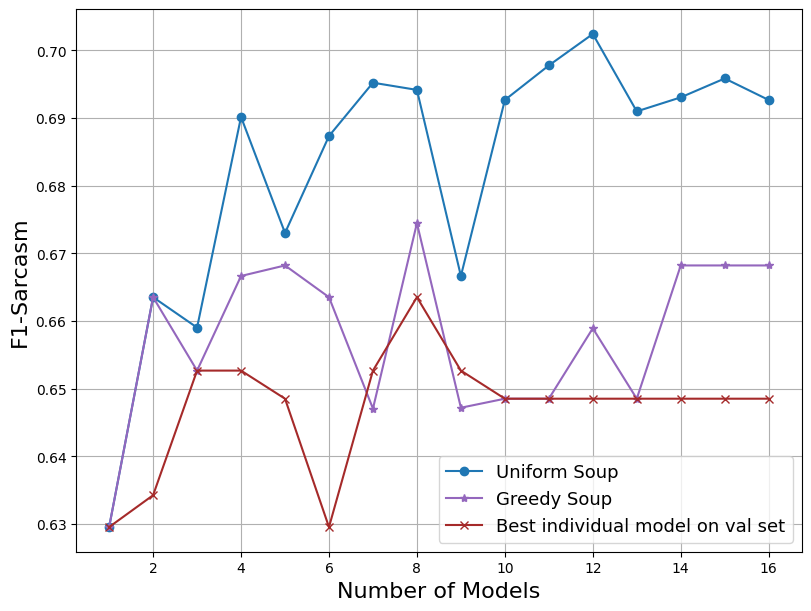

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(8, 6))
ax = fig.subplots()
ax.plot(
    uniform_soup_model_db_t['total_models'].values,
    uniform_soup_model_db_t['f1_sarcastic'].values,
    marker='o',
    color='C0',
    # s=130,
    label='Uniform Soup',
    zorder=10
)
ax.plot(
    greedy_soup_model_db_t['total_models'].values,
    greedy_soup_model_db_t['f1_sarcastic'].values,
    marker='*',
    color='C4',
    # s=130,
    label='Greedy Soup',
    zorder=10
)
ax.plot(
    best_model_db_h['total_models'].values,
    best_model_db_h['f1_sarcastic'].values,
    marker='x',
    color='Brown',
    # s=130,
    label='Best individual model on val set',
    zorder=10
)
# ax.hlines(

#     y = avg_best_model_db_h['f1_sarcastic'],
#     linestyles='--',
#     # marker='-',
#     color='Grey',
#     # s=130,
#     label='Avg individual model on val set',
#     zorder=10,
#     xmin =1,
#     xmax = 16
# )


ax.set_ylabel('F1-Sarcasm', fontsize=16)
ax.set_xlabel('Number of Models', fontsize=16)
ax.grid()
ax.legend(fontsize=13)
plt.savefig('figure_t.png', bbox_inches='tight')

KeyError: ignored

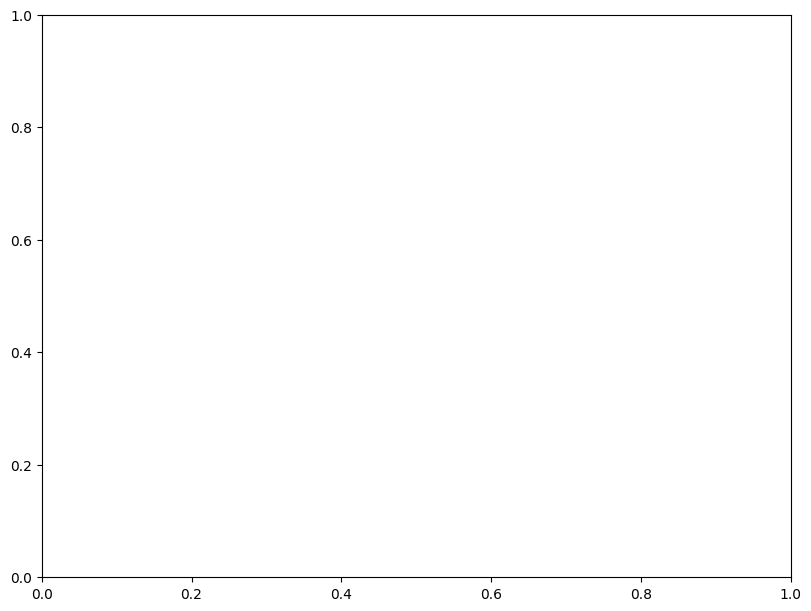

In [ ]:


# array=[]
# array = [i+4 for i in range(len(individual_model_db_t))]
# # print(array)
fig = plt.figure(constrained_layout=True, figsize=(8, 6))
ax = fig.subplots()

ax.scatter(
    1,
    greedy_soup_model_db_t['f1_sarcastic'],
    marker='*',
    color='C4',
    s=400,
    label='Greedy Soup',
    zorder=10
)

ax.scatter(
    2,
    uniform_soup_model_db_t['f1_sarcastic'],
    marker='o',
    color='C0',
    s=200,
    label='Uniform Soup',
    zorder=10
)

ax.scatter(
          3,
          best_model_db_h['f1_sarcastic'],
          marker='h',
          color='slategray',
          s=150,
          label='Best Model',
          zorder=10
      )
ax.scatter(
    array,
    individual_model_db_t['f1_sarcastic'].values,
    marker='d',
    color='C2',
    s=130,
    label='Various hyperparameters',
    zorder=10
)

ax.set_ylabel('F1-Sarcasm', fontsize=16)
ax.set_xlabel('Model Id', fontsize=16)
ax.grid()
ax.legend(fontsize=13)
plt.savefig('figure_t.png', bbox_inches='tight')

In [ ]:
ls

drive/                       results/
figure_f1_h.png              sample_data/
figure_t.png                 ssd/
greedy_base_model.pth        uniform_base_model.pth
greedy_classifier.pth        uniform_classifier.pth
greedy_soup_results_h.jsonl  uniform_soup_results_h.jsonl
greedy_soup_results_t.jsonl  uniform_soup_results_t.jsonl


In [ ]:
ls '/content/drive/MyDrive/iSarcasm/m_5751_298'

 results/  'Untitled folder'/


In [ ]:
!mkdir /content/drive/MyDrive/iSarcasm/m_5751_298/results_all_f1

In [ ]:
%cp uniform_soup_results_h.jsonl /content/drive/MyDrive/iSarcasm/m_298/results_i
%cp uniform_soup_results_t.jsonl /content/drive/MyDrive/iSarcasm/m_298/results_i

In [ ]:
%cp greedy_soup_results_t.jsonl /content/drive/MyDrive/iSarcasm/m_298/results_i
%cp greedy_soup_results_h.jsonl /content/drive/MyDrive/iSarcasm/m_298/results_i

In [ ]:

# %cp individual_model_results_h.jsonl /content/drive/MyDrive/iSarcasm/m_5751_298/results_all_f1

# %cp individual_model_results_t.jsonl /content/drive/MyDrive/iSarcasm/m_5751_298/results_all_f1


%cp best_model_f.jsonl /content/drive/MyDrive/iSarcasm/m_5751_298/results_all_f1


%cp figure_h.png /content/drive/MyDrive/iSarcasm/m_5751_298/results_all_f1
%cp figure_t.png /content/drive/MyDrive/iSarcasm/m_5751_298/results_all_f1


%cp greedy_base_model.pth /content/drive/MyDrive/iSarcasm/m_5751_298/results_all_f1
%cp greedy_classifier.pth /content/drive/MyDrive/iSarcasm/m_5751_298/results_all_f1
%cp uniform_base_model.pth /content/drive/MyDrive/iSarcasm/m_5751_298/results_all_f1
%cp uniform_classifier.pth /content/drive/MyDrive/iSarcasm/m_5751_298/results_all_f1

cp: cannot stat 'best_model_f.jsonl': No such file or directory


In [ ]:
%cp figure_t.png /content/drive/MyDrive/iSarcasm/m_298/results_i

In [ ]:
ex_loader = loadExamplesData(batchsize=args['batch_size'], num_worker=0, pretraine_path=args['pretrained_path'],  max_length=args['max_length'])


In [ ]:
ex_accuracies,ex_outputs, ex_labels = eval_full(args, ex_loader,  uniform_soup_base_model, uniform_soup_classifier )


10/10: [>...............................] - ETA 0.0s


In [ ]:
ex_accuracies,ex_outputs, ex_labels

({'accuracy': 1.0,
  'f1_sarcastic': 1.0,
  'f1_score': 1.0,
  'report_sarcasm': '              precision    recall  f1-score   support\n\n         0.0     1.0000    1.0000    1.0000         5\n         1.0     1.0000    1.0000    1.0000         5\n\n    accuracy                         1.0000        10\n   macro avg     1.0000    1.0000    1.0000        10\nweighted avg     1.0000    1.0000    1.0000        10\n'},
 array([0., 1., 0., 1., 0., 1., 0., 1., 0., 1.]),
 array([0., 1., 0., 1., 0., 1., 0., 1., 0., 1.]))

In [ ]:
ex_accuracies,ex_outputs, ex_labels = eval_full(args, ex_loader,  greedy_soup_base_model, greedy_soup_classifier )

10/10: [>...............................] - ETA 0.0s


In [ ]:
ex_accuracies,ex_outputs, ex_labels

({'accuracy': 1.0,
  'f1_sarcastic': 1.0,
  'f1_score': 1.0,
  'report_sarcasm': '              precision    recall  f1-score   support\n\n         0.0     1.0000    1.0000    1.0000         5\n         1.0     1.0000    1.0000    1.0000         5\n\n    accuracy                         1.0000        10\n   macro avg     1.0000    1.0000    1.0000        10\nweighted avg     1.0000    1.0000    1.0000        10\n'},
 array([0., 1., 0., 1., 0., 1., 0., 1., 0., 1.]),
 array([0., 1., 0., 1., 0., 1., 0., 1., 0., 1.]))

In [ ]:
ls '/content/drive/MyDrive/iSarcasm/m_298/results_all_f1/greedy_base_model.pth '

figure_h.png                 greedy_soup_results_t.jsonl
figure_t.png                 uniform_base_model.pth
greedy_base_model.pth        uniform_classifier.pth
greedy_classifier.pth        uniform_soup_results_h.jsonl
greedy_soup_results_h.jsonl  uniform_soup_results_t.jsonl


In [ ]:
base_model = TransformerLayer(pretrained_path=args['pretrained_path'], both=True).to(device)

base_model.load_state_dict(torch.load('/content/drive/MyDrive/iSarcasm/m_298/results_all_f1/greedy_base_model.pth'))
# ls ./ssd/checkpoints/soups
state_dict_cls = torch.load('/content/drive/MyDrive/iSarcasm/m_298/results_all_f1/greedy_classifier.pth')

classifier = get_model_from_sd(state_dict_cls, base_model)

base_model = base_model.to(device)
classifier = classifier.to(device)

val_accuracies,val_outputs, val_labels = eval_full(args, ex_loader,  base_model, classifier )

val_accuracies,val_outputs, val_labels

In [ ]:
base_model = TransformerLayer(pretrained_path=args['pretrained_path'], both=True).to(device)

base_model.load_state_dict(torch.load('/content/drive/MyDrive/iSarcasm/m_298/results_all_f1/uniform_base_model.pth'))
# ls ./ssd/checkpoints/soups
state_dict_cls = torch.load('/content/drive/MyDrive/iSarcasm/m_298/results_all_f1/uniform_classifier.pth')

classifier = get_model_from_sd(state_dict_cls, base_model)

base_model = base_model.to(device)
classifier = classifier.to(device)

val_accuracies,val_outputs, val_labels = eval_full(args, ex_loader,  base_model, classifier )

val_accuracies,val_outputs, val_labels

10/10: [>...............................] - ETA 0.0s


({'accuracy': 1.0,
  'f1_sarcastic': 1.0,
  'f1_score': 1.0,
  'report_sarcasm': '              precision    recall  f1-score   support\n\n         0.0     1.0000    1.0000    1.0000         5\n         1.0     1.0000    1.0000    1.0000         5\n\n    accuracy                         1.0000        10\n   macro avg     1.0000    1.0000    1.0000        10\nweighted avg     1.0000    1.0000    1.0000        10\n'},
 array([0., 1., 0., 1., 0., 1., 0., 1., 0., 1.]),
 array([0., 1., 0., 1., 0., 1., 0., 1., 0., 1.]))